<a href="https://colab.research.google.com/github/martuscellifaria/FluidsAndAcoustics/blob/master/AirfoilParamPanel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Airfoil parametrization and lift coefficient estimation based on panel method**
The final objective is to optimize airfoil geometries for Wind Turbine applications. First, the David Ziemkiewicz function is implemented (see in https://arxiv.org/pdf/1701.00817.pdf), so the panel method is applied in order to discretize the airfoil and set it ready to aerodynamics and aeroacoustics calculations. Then, the optimization method shall be implemented in order to set aerodynamic noise as a design constraint.

## **1 Libraries definition**
First things first, yet again, right?

In [1]:
import numpy as np
import pandas as pd
from scipy import integrate, linalg
from matplotlib import pyplot as plt
# integrate plots into the notebook
%matplotlib inline

## **2 Set the initial design constraints and all fluid properties**
Ya know, Mach, Reynolds, desired thickness, viscosity, density. That will be important, trust me!

In [24]:
M = 0.21
Re = 7000000
rho = 1.225 #kg/m³
mu = 1.81*(10**(-5)) #Pa*s
c_0 = 340 #m/s
des_max_th = 21 #% for WT airfoils
alpha = 0 #Angle of Attack

## **2.1 Obtain the airfoil chord**

In [9]:
u = M*c_0
chord = Re*mu/(rho*u)
print('The airfoil has a chord of approximate {:0.2} m'.format(chord))

The airfoil has a chord of approximate 1.4 m


## **2.2 Set the values for the parametrization**

In [71]:
Np = 51 #number of panels
theta = np.linspace(0, 2*np.pi, Np)
B = 2.2 #For NACA profiles B = 2
T = (des_max_th/12)*(np.pi/17) #For max 12% set T = np.pi/17
P = 0.9 #For NACA profiles P = 1
C = 0.07 #For NACA profiles C = 0
E = 1.01 #For NACA profiles E = 0
R = 0 #For NACA profiles R = 0

## **2.3 Run the parametrization**

In [72]:
X = ((0.5*abs(np.cos(theta))**B/np.cos(theta))+0.5)
Th = (T/2)*(abs(np.sin(theta))**B/np.sin(theta))*((1-X)**P)
Th[0] = 0 #To avoid division by zero for theta = 0
Cm = (C*np.sin(np.pi*X**E))+(R*np.sin(2*np.pi*X))
Y = Th + Cm
x = chord*X
y = chord*Y

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


## **2.4 Plot the airfoil**

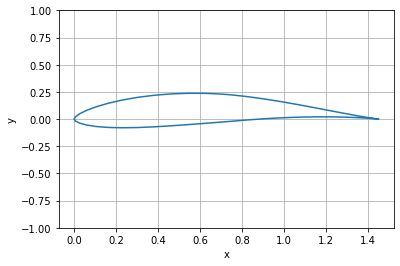

In [73]:
plt.figure()
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('y')
#plt.xlim([0, 1])
#plt.axis('scaled', adjustable='box')
#plt.xlim(-0.1, 1.1)
plt.ylim([-1, 1])
plt.grid(which='major')
plt.grid(which='minor')
plt.show()

## **3 Panel method**

In [74]:
class Panel:
    def __init__(self, xa, ya, xb, yb):
        self.xa, self.ya = xa, ya  # panel starting-point
        self.xb, self.yb = xb, yb  # panel ending-point
        
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2  # panel center
        self.length = np.sqrt((xb - xa)**2 + (yb - ya)**2)  # panel length
        
        # orientation of panel (angle between x-axis and panel's normal)
        if xb - xa <= 0.0:
            self.beta = np.arccos((yb - ya) / self.length)
        elif xb - xa > 0.0:
            self.beta = np.pi + np.arccos(-(yb - ya) / self.length)
        
        # panel location
        if self.beta <= np.pi:
            self.loc = 'upper'  # upper surface
        else:
            self.loc = 'lower'  # lower surface
        
        self.sigma = 0.0  # source strength
        self.vt = 0.0  # tangential velocity
        self.cp = 0.0  # pressure coefficient

In [75]:
def define_panels(x, y, N=Np):

    
    R = (x.max() - x.min()) / 2.0  # circle radius
    x_center = (x.max() + x.min()) / 2.0  # x-coordinate of circle center
    
    theta = np.linspace(0.0, 2.0 * np.pi, N + 1)  # array of angles
    x_circle = x_center + R * np.cos(theta)  # x-coordinates of circle
    
    x_ends = np.copy(x_circle)  # x-coordinate of panels end-points
    y_ends = np.empty_like(x_ends)  # y-coordinate of panels end-points
    
    # extend coordinates to consider closed surface
    x, y = np.append(x, x[0]), np.append(y, y[0])
    
    # compute y-coordinate of end-points by projection
    I = 0
    for i in range(N):
        while I < len(x) - 1:
            if (x[I] <= x_ends[i] <= x[I + 1]) or (x[I + 1] <= x_ends[i] <= x[I]):
                break
            else:
                I += 1
        a = (y[I + 1] - y[I]) / (x[I + 1] - x[I])
        b = y[I + 1] - a * x[I + 1]
        y_ends[i] = a * x_ends[i] + b
    y_ends[N] = y_ends[0]
    
    # create panels
    panels = np.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i + 1], y_ends[i + 1])
    
    return panels

In [76]:
# discretize geoemetry into panels
panels = define_panels(x, y, N=Np-1)

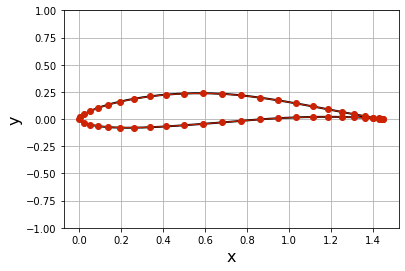

In [77]:
# plot discretized geometry
#width = 10
plt.figure()#(figsize=(width, width))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x, y, color='k', linestyle='-', linewidth=2)
plt.plot(np.append([panel.xa for panel in panels], panels[0].xa),
            np.append([panel.ya for panel in panels], panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
#plt.axis('scaled', adjustable='box')
#plt.xlim(-0.1, 1.1)
plt.ylim([-1, 1])
plt.show()

In [78]:
class Freestream:
    def __init__(self, u, alpha):
        self.u = u
        self.alpha = np.radians(alpha)  # degrees to radians

In [79]:
# define freestream conditions
freestream = Freestream(u, alpha)

In [80]:
def integral(x, y, panel, dxdk, dydk):
    def integrand(s):
        return (((x - (panel.xa - np.sin(panel.beta) * s)) * dxdk +
                 (y - (panel.ya + np.cos(panel.beta) * s)) * dydk) /
                ((x - (panel.xa - np.sin(panel.beta) * s))**2 +
                 (y - (panel.ya + np.cos(panel.beta) * s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [81]:
def source_contribution_normal(panels):
    A = np.empty((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    np.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / np.pi * integral(panel_i.xc, panel_i.yc, 
                                                    panel_j,
                                                    np.cos(panel_i.beta),
                                                    np.sin(panel_i.beta))
    return A

In [82]:
def vortex_contribution_normal(panels):
    A = np.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    np.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5 / np.pi * integral(panel_i.xc, panel_i.yc, 
                                                     panel_j,
                                                     np.sin(panel_i.beta),
                                                     -np.cos(panel_i.beta))
    return A

In [83]:
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  import sys


In [84]:
def kutta_condition(A_source, B_vortex):
    b = np.empty(A_source.shape[0] + 1, dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    b[:-1] = B_vortex[0, :] + B_vortex[-1, :]
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    b[-1] = - np.sum(A_source[0, :] + A_source[-1, :])
    return b

In [85]:
def build_singularity_matrix(A_source, B_vortex):
    A = np.empty((A_source.shape[0] + 1, A_source.shape[1] + 1), dtype=float)
    # source contribution matrix
    A[:-1, :-1] = A_source
    # vortex contribution array
    A[:-1, -1] = np.sum(B_vortex, axis=1)
    # Kutta condition array
    A[-1, :] = kutta_condition(A_source, B_vortex)
    return A

In [86]:
def build_freestream_rhs(panels, freestream):
    b = np.empty(panels.size + 1, dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels):
        b[i] = -freestream.u * np.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition
    b[-1] = -freestream.u * (np.sin(freestream.alpha - panels[0].beta) +
                                 np.sin(freestream.alpha - panels[-1].beta) )
    return b

In [87]:
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels, freestream)

In [88]:
# solve for singularity strengths
strengths = np.linalg.solve(A, b)

# store source strength on each panel
for i , panel in enumerate(panels):
    panel.sigma = strengths[i]
    
# store circulation density
gamma = strengths[-1]

In [89]:
def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
    A = np.empty((panels.size, panels.size + 1), dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    A[:, :-1] = B_vortex
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    A[:, -1] = -np.sum(A_source, axis=1)
    # freestream contribution
    b = freestream.u * np.sin([freestream.alpha - panel.beta 
                                      for panel in panels])
    
    strengths = np.append([panel.sigma for panel in panels], gamma)
    
    tangential_velocities = np.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]

In [90]:
# tangential velocity at each panel center.
compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)

In [91]:
def compute_pressure_coefficient(panels, freestream):
    for panel in panels:
        panel.cp = 1.0 - (panel.vt / freestream.u)**2

In [92]:
# surface pressure coefficient
compute_pressure_coefficient(panels, freestream)

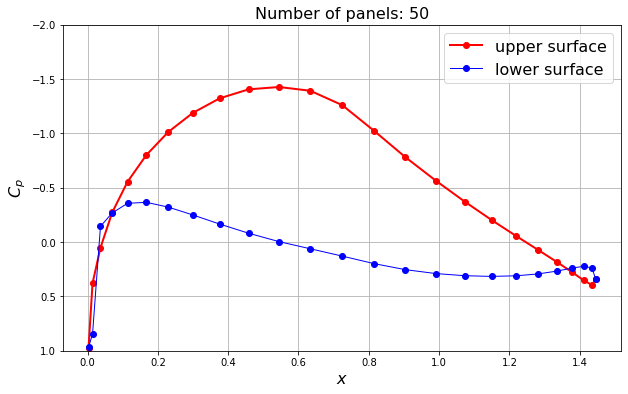

In [93]:
# plot surface pressure coefficient
plt.figure(figsize=(10, 6))
plt.grid()
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)
plt.plot([panel.xc for panel in panels if panel.loc == 'upper'],
            [panel.cp for panel in panels if panel.loc == 'upper'],
            label='upper surface',
            color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
plt.plot([panel.xc for panel in panels if panel.loc == 'lower'],
            [panel.cp for panel in panels if panel.loc == 'lower'],
            label= 'lower surface',
            color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
plt.legend(loc='best', prop={'size':16})
#plt.xlim(-0.1, 1.1)
plt.ylim(1.0, -2.0)
plt.title('Number of panels: {}'.format(panels.size), fontsize=16)
plt.show()

In [94]:
# calculate the accuracy
accuracy = sum([panel.sigma * panel.length for panel in panels])
print('sum of singularity strengths: {:0.6f}'.format(accuracy))

sum of singularity strengths: 0.769015


In [95]:
# compute the chord and lift coefficient
c = abs(max(panel.xa for panel in panels) -
        min(panel.xa for panel in panels))
cl = (gamma * sum(panel.length for panel in panels) /
      (0.5 * freestream.u * c))
print('lift coefficient: CL = {:0.3f}'.format(cl))

lift coefficient: CL = 0.855
